In [6]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
from quality.analyze_types import create_typed_predictions

In [15]:
kg1_ent_id_files = sorted([i for i in glob.iglob("../../output/results/BootEA/D_W_15K_V1/721_5fold/*/*/kg1_ent_ids")])
kg2_ent_id_files = sorted([i for i in glob.iglob("../../output/results/BootEA/D_W_15K_V1/721_5fold/*/*/kg2_ent_ids")])
pred_files = sorted([i for i in glob.iglob("../../data/output/results/D_W_15K_V1-721_5fold-*/BootEA/datasets/*/D_W_15K_V1-721_5fold-*-boot_ea_random forest 500_SimAndEmb_test_pred.csv")])
type_files = sorted([i for i in glob.iglob("../../data/OpenEA/typed_links/datasets/D_W_15K_V1/721_5fold/*/typed_test")])

In [16]:
df = create_typed_predictions(
    kg1_ent_id_files,
    kg2_ent_id_files,
    pred_files,
    type_files,
    "../../data/OpenEA/typed_links/datasets/D_W_15K_V1/",
    1,
    False
)
false_negatives = df.loc[(df["pred"]==0) & (df["val"]==1)]
false_positives = df.loc[(df["pred"]==1) & (df["val"]==0)]

Getting type occurences: 15it [00:01,  9.42it/s]
Enrich predictions: 100%|██████████| 21000/21000 [00:00<00:00, 161095.74it/s]


In [17]:
fp_type_counts = false_positives["left_types"].value_counts().to_frame().join(false_positives["right_types"].value_counts().to_frame())
fp_type_counts["types"] = fp_type_counts["left_types"] + fp_type_counts["right_types"]
#fp_type_counts["type"] = fp_type_counts["type"]/fp_type_counts["type"].sum()
fp_type_counts.drop(labels=["left_types","right_types"],axis=1,inplace=True)

In [21]:
fn_type_counts = false_negatives["left_types"].value_counts().to_frame()
df_left_types = ((df["left_types"].value_counts() + df["right_types"].value_counts())/2).to_frame(name="types")
combined = df_left_types.join(fn_type_counts)
combined = combined.join(fp_type_counts, lsuffix="ALL", rsuffix="FP")
combined.reset_index(inplace=True)
combined = combined.rename(columns={"index":"Type Name","typesALL":"All test links","left_types":"False Negative","typesFP":"False Positive"})
combined["Type Name"] = [x.split('/')[-1].split('#')[-1] for x in combined["Type Name"].astype(str)]
combined = combined[combined["All test links"] >= 50]
#combined = combined.iloc[:50]
combined["False Positive"] = combined["False Positive"]/combined["All test links"]
combined["False Negative"] = combined["False Negative"]/combined["All test links"]
combined["All test links"] = combined["All test links"]/combined["All test links"].sum()
combined = combined.sort_values(by="All test links",ascending=False)
combined

,Type Name,All test links,False Negative,False Positive
27,Film,0.329112,0.078876,0.000204
2,Agent,0.321043,0.134178,0.000448
38,MusicalWork,0.151742,0.271432,0.000126
42,Place,0.067856,0.125777,0.000707
60,TelevisionEpisode,0.023015,0.195000,NaN
55,Software,0.021145,0.250340,0.000907
61,TelevisionShow,0.018853,0.193795,NaN
41,Person,0.018801,0.197399,NaN
13,Book,0.017755,0.277613,0.001080
24,Eukaryote,0.004613,0.264033,NaN


In [22]:
combined_melted = pd.melt(combined, id_vars="Type Name", var_name="Test Data Slice", value_name="Value")
combined_melted

,Type Name,Test Data Slice,Value
0,Film,All test links,0.329112
1,Agent,All test links,0.321043
2,MusicalWork,All test links,0.151742
3,Place,All test links,0.067856
4,TelevisionEpisode,All test links,0.023015
5,Software,All test links,0.021145
6,TelevisionShow,All test links,0.018853
7,Person,All test links,0.018801
8,Book,All test links,0.017755
9,Eukaryote,All test links,0.004613


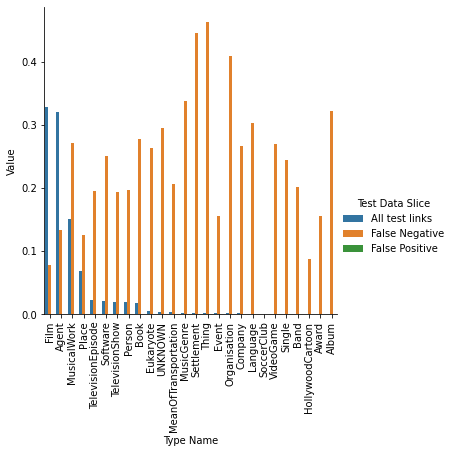

In [23]:
#g = sns.barplot(x="Type Name", y="Type Occurence", data=combined)
g = sns.catplot(x='Type Name', y='Value', hue='Test Data Slice', data=combined_melted, kind='bar')
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)